#DoA estimation from one-bit quantized measurements#


In [12]:
import numpy as np
import torch as tc
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from google.colab import drive
import  pickle
import copy
import scipy
import torch.nn.init as init
import pickle
from torch.utils.data import DataLoader
import time

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
class struct():
    '''
    an empty class to use structure type variable
    '''
    pass

In [69]:
def  data_generation(params):
  np.random.seed(2023)
  M=params.num_antenna
  L=params.grid.size
  whole_dataset_size=params.whole_dataset_size

  A_unnormalized,Phi_fix,norms=generate_A(params)
  C=np.diag(1/norms)
  b = np.zeros((whole_dataset_size,2*(M**2)))
  z = np.zeros((whole_dataset_size,2*(M**2)))
  nu=np.zeros((whole_dataset_size, L))
  A = np.zeros((whole_dataset_size,2*(M**2), L))
  for i in range(whole_dataset_size):
     b[i],z[i],nu[i]=one_bit_cov_est(params,A_unnormalized)
     nu[i]=np.diag(norms) @ nu[i]
     A[i]=Phi_fix


  params.x=nu
  params.b=b-z
  params.A=A



  return

def  one_bit_cov_est(params,A):
  M=params.num_antenna
  N=params.N
  L=params.grid.size
  a=params.a
  p=np.zeros((L,N))
  non_zero_indices=np.random.choice(L, size=params.sparsity, replace=False)
  for  i  in range(N):
     non_zero_values = np.random.uniform(0, a, params.sparsity)
     p[non_zero_indices,i] = non_zero_values
  nu= np.var(p, axis=1, ddof=1)
  noise= np.random.normal(0, np.sqrt(params.noise_sigma_2),(M,N))+1j*np.random.normal(0, np.sqrt(params.noise_sigma_2),(M,N))

  X= A @ p+ noise
  one_bit_data_real, one_bit_data_imag=two_bit_quantizer(X,params)
  r_1=one_bit_data_real+1j*one_bit_data_imag

  one_bit_data_real, one_bit_data_imag=two_bit_quantizer(X,params)
  r_2=one_bit_data_real+1j*one_bit_data_imag


  R_X=sample_covariance(M,N,X,X)
  R_X=1/(N)*R_X
  R_1_hat=((2*a)**2/N)*sample_covariance(M,N,r_1,r_2)

  R=0.5*(R_1_hat+R_1_hat.conj().T)
  y_bar=R.T.flatten()



  b=np.hstack((np.real(y_bar),np.imag(y_bar)))


  t1=params.noise_sigma_2*np.identity(M).T.reshape(-1,1)

  t2=np.zeros((M**2,1))

  z= np.squeeze(np.vstack((t1,t2)))


  return  b,z,nu

def  sample_covariance(M,N,r_1,r_2):
  result =np.zeros((M,M),dtype=complex)
  for n in range(N):
    column_product = np.outer(r_1[:, n], np.conjugate(r_2[:, n]))
    result += column_product
  return result



def  two_bit_quantizer(X,params):
    M=params.num_antenna
    N=params.N
    a=params.a
    threshold1=np.random.uniform(-2*a, 2*a, (M,N))
    threshold2=np.random.uniform(-2*a, 2*a, (M,N))
    X_r=np.real(X)
    X_i=np.imag(X)
    one_bit_data_real=np.ones((M,N))
    one_bit_data_imag=np.ones((M,N))

    indices_real= np.where(X_r - threshold1 < 0)
    one_bit_data_real[indices_real]=-1

    indices_imag= np.where(X_i - threshold2 < 0)
    one_bit_data_imag[indices_imag]=-1

    return  one_bit_data_real, one_bit_data_imag

def  generate_A(params):

   n=params.n
   grid=params.grid
   L=grid.size
   num_antenna=params.num_antenna
   A=(1+1j)*np.ones((num_antenna,L))
   for  l in range(L):
      t=steering(num_antenna,grid[l])
      A[:, l] = t.flatten()
   C=scipy.linalg.khatri_rao(A.conj(), A)
   B=np.vstack((np.real(C),np.imag(C)))

   norms = np.linalg.norm(B, axis=0, ord=2)
   Phi_normalized = B @  np.diag(1/norms)


   return A, Phi_normalized,norms


def steering(K,theta):
 steer_vec=np.exp(1j*np.pi*np.sin(theta)*np.arange(0,K,1) )  # d is set to  lambda/2
 steer_vec=np.transpose(steer_vec[np.newaxis])

 return  steer_vec


class LISTA_CP(tc.nn.Module):
    def __init__(self,params):
      super(LISTA_CP, self).__init__()

      self.K=params.Layers
      batch=params.BATCH_SIZE
      n=params.n
      m=params.m
      Layers=params.Layers



      self.W = nn.ModuleList([nn.Linear(m,n,bias=False) for _ in range(Layers)])


      self.theta=nn.ParameterList([nn.Parameter(tc.tensor(0.005)) for _ in range(Layers)])

      for k in range(Layers):
            init.uniform_(self.theta[k], a=0, b=1e-5)
      self.x_init =tc.zeros((batch,n,1),dtype = tc.float32)
      self.x_layer =tc.zeros((batch,Layers,n,1),dtype = tc.float32)

    def forward(self,b,A):
      x_k=self.x_init
      b=b.to(tc.float32)
      A=A.to(tc.float32)
      for  k in range(self.K):


            temp1=x_k.squeeze(2)+self.W[k](b-tc.matmul(A,x_k).squeeze(2))

            x_k =tc.nn.functional.relu(temp1.unsqueeze(2) -self.theta[k])- tc.nn.functional.relu(-temp1.unsqueeze(2)- self.theta[k])


      return  x_k

def  prepare_train_test(params,mode=0):
  x_train=params.x_train
  x_test=params.x_test
  A_train=params.A_train,
  A_test=params.A_test
  BATCH_SIZE=params.BATCH_SIZE
  if mode==0:
     b_train=params.b_train
     b_test=params.b_test
  elif mode==1:
     b_train=params.b_train_q
     b_test=params.b_test_q


  # convert data to  iterables
  trainset = []
  A_train=np.squeeze(np.array(A_train))

  for i in range(len(x_train)):
        trainset.append([A_train[i], x_train[i], b_train[i]])
  train_loader= DataLoader(trainset, shuffle=False, batch_size=BATCH_SIZE)
  testset = []

  for i in range(len(x_test)):
        testset.append([A_test[i],x_test[i], b_test[i]])
  test_loader= DataLoader(testset, shuffle=False, batch_size=BATCH_SIZE)
  return train_loader,test_loader


def train(model,params,train_loader,test_loader):
   NUM_EPOCHS=params.NUM_EPOCHS
   report=struct()

   criterion = tc.nn.MSELoss(reduction='sum') # square error loss
   optimizer = tc.optim.Adam(model.parameters(),lr=params.lr)
   scheduler = tc.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=3,verbose=True) # it can be adjusted later
   train_loss_ep=[]
   test_loss_ep=[]
   for epoch in range(NUM_EPOCHS):
      losses=[]
      train_loss_report=0
      c=0
      for batch in train_loader:
           A,x,b=batch
           x=x.to(tc.float32)
           b=b.to(tc.float32)
           A=A.to(tc.float32)
           x_hat=model(b,A)
           loss=criterion(x_hat,x.unsqueeze(2)) # our objective function

           optimizer.zero_grad()

           loss.backward()

           optimizer.step()

           losses.append(loss.item())

      mean_loss=sum(losses)/len(losses)
      scheduler.step(mean_loss)

      if epoch%1==0:
          test_loss=0
          c=0
          for batch in test_loader:
            A,x,b=batch
            x=x.to(tc.float32)
            b=b.to(tc.float32)
            x_hat=model(b,A)


            test_loss+=mse(x_hat,x)
            c+=1
          test_loss=test_loss/c
          test_loss_ep.append(test_loss.item())
          c=0
          train_loss=0
          for batch in train_loader:
            A,x,b=batch
            x=x.to(tc.float32)
            b=b.to(tc.float32)
            x_hat=model(b,A)
            train_loss+=mse(x_hat,x)
            c+=1
          train_loss=train_loss/c
          train_loss_ep.append(train_loss.item())
          print('Epoch {}/{}'.format(epoch, NUM_EPOCHS),'Train LOSS: {:.2f}'.format(train_loss.item()),'test LOSS: {:.2f}'.format(test_loss.item()),'|| {:.2f}'.format(10*np.log10(test_loss.item())),'dB\n')


   return  train_loss_ep,test_loss_ep

def mse(x, x_star):

    x_star=x_star.unsqueeze(2)
    norm_x_star = tc.norm(x_star, dim=1)**2
    temp=tc.sum((x - x_star)**2,dim=1)



    nmse = tc.mean(temp)

    return nmse


def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def keep_largest_elements(vector, num_elements_to_keep):
    # Get the indices that would sort the vector in descending order
    sorted_indices = np.argsort(-vector)

    # Keep only the indices corresponding to the largest elements
    largest_indices = sorted_indices[:num_elements_to_keep]

    # Create a mask where only the largest elements are True
    mask = np.zeros_like(vector)
    mask[largest_indices] = 1

    # Apply the mask to the vector to keep only the largest elements
    vector1 = vector.copy()
    vector1[mask == 0] = 0

    return vector1


##**Parameters**##

In [36]:
params=struct()
params.Layers                =10
params.whole_dataset_size    =1000

params.sparsity              =3
params.BATCH_SIZE            =20
params.NUM_EPOCHS            =100
params.lr                    =1e-3                           # 1e-3 is  best
params.randomseed            =2023                           #for  fixing the randomness
params.grid                  =np.arange(-np.pi/3, np.pi/3, 3*np.pi/180)
params.num_antenna           =16
params.N                     =5000                          # number of snap shots
params.m                     =2*params.num_antenna**2       #input size of LISTA
params.n                     =params.grid.size              # size of original signal
params.noise_sigma_2         =1e-4
params.a                     =1


with open('/content/gdrive/My Drive/Colab Notebooks/LISTA/params.pkl', 'wb') as file:
    pickle.dump(params, file)

['BATCH_SIZE', 'Layers', 'N', 'NUM_EPOCHS', 'SNR', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'a', 'bit', 'grid', 'lr', 'm', 'n', 'noise_sigma_2', 'num_antenna', 'randomseed', 'sparsity', 'whole_dataset_size']


##DoA  estimation from one bit Quantized data##

In [37]:
tc.manual_seed(4)
tc.cuda.empty_cache()
_= data_generation(params)


params.x_train, params.x_test, params.A_train, params.A_test, params.b_train, params.b_test = train_test_split(params.x, params.A,params.b, test_size=0.2, random_state=2)
train_loader,test_loader= prepare_train_test(params, mode=0)   #Mode=0  high resolution,    Mode=1  quantized
# Save train_loader and test_loader to a file
with open('/content/gdrive/My Drive/dataloaders.pkl', 'wb') as file:
    pickle.dump((train_loader, test_loader), file)


print('end of data generation')



end of data generation


## Load the Data and train

In [38]:
# Load train_loader and test_loader from the file
with open('/content/gdrive/My Drive/dataloaders.pkl', 'rb') as file:
    loaded_train_loader, loaded_test_loader = pickle.load(file)

model=LISTA_CP(params)
params.train_loss,params.test_loss= train(model,params,loaded_train_loader,loaded_test_loader)
print(model.x_layer.shape)

Epoch 0/100 Train LOSS: 6.30 test LOSS: 7.63 || 8.82 dB

Epoch 1/100 Train LOSS: 2.56 test LOSS: 3.78 || 5.77 dB

Epoch 2/100 Train LOSS: 1.77 test LOSS: 2.99 || 4.75 dB

Epoch 3/100 Train LOSS: 1.46 test LOSS: 2.66 || 4.25 dB

Epoch 4/100 Train LOSS: 1.27 test LOSS: 2.48 || 3.94 dB

Epoch 5/100 Train LOSS: 1.10 test LOSS: 2.27 || 3.55 dB

Epoch 6/100 Train LOSS: 0.99 test LOSS: 2.11 || 3.25 dB

Epoch 7/100 Train LOSS: 0.91 test LOSS: 2.01 || 3.04 dB

Epoch 8/100 Train LOSS: 0.80 test LOSS: 1.86 || 2.69 dB

Epoch 9/100 Train LOSS: 0.73 test LOSS: 1.84 || 2.64 dB

Epoch 10/100 Train LOSS: 0.72 test LOSS: 1.80 || 2.55 dB

Epoch 11/100 Train LOSS: 0.67 test LOSS: 1.72 || 2.36 dB

Epoch 12/100 Train LOSS: 0.62 test LOSS: 1.67 || 2.23 dB

Epoch 13/100 Train LOSS: 0.64 test LOSS: 1.65 || 2.18 dB

Epoch 14/100 Train LOSS: 0.60 test LOSS: 1.64 || 2.15 dB

Epoch 15/100 Train LOSS: 0.67 test LOSS: 1.77 || 2.48 dB

Epoch 16/100 Train LOSS: 0.74 test LOSS: 1.91 || 2.82 dB

Epoch 17/100 Train LOSS:

probability: 1.0


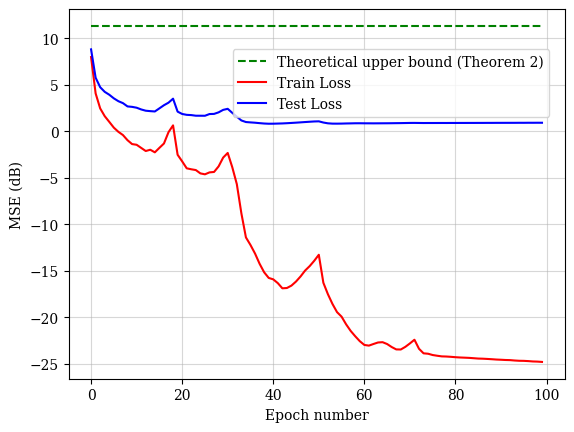

Final NMSE = 0.93 with # of Layers=10


In [72]:


for layer in model.W:
  for param in layer.parameters():
     max_abs_weight = param.data.abs().max().item()
c=2
t=0.01
print("probability:", 1-8*np.exp(-c*params.N*t))
s=params.sparsity
B=params.a/12
T=2*params.a
i=params.Layers
M=params.num_antenna
N=params.N
upper_bound=s*B*np.exp(-c*i)+ 2*s*max_abs_weight*T**2 * M**2 * np.sqrt((np.log2(M)+t)/N)

plt.rcParams['font.family'] = 'serif'

train_loss=params.train_loss
test_loss=params.test_loss
plt.plot(np.arange(0,len(train_loss[:200]),1),[10*np.log10(upper_bound)]*len(train_loss[:200]),'g--',label='Theoretical upper bound (Theorem 2)')
plt.plot(np.arange(0,len(train_loss[:200]),1),10*np.log10(train_loss)[:200],'r',label='Train Loss')
plt.plot(np.arange(0,1*len(test_loss[:200]),1),10*np.log10(test_loss)[:200],'b',label='Test Loss')
plt.ylabel('MSE (dB)')
plt.xlabel('Epoch number')
plt.legend(loc='center', bbox_to_anchor=(0.65, 0.8))
plt.grid(alpha=0.5)
plt.savefig("/content/gdrive/My Drive/Images/Fig8_DoA_estimation.eps", format="eps", bbox_inches="tight", transparent=True)

plt.show()
print('Final NMSE = {:.2f}'.format(10*np.log10(test_loss)[-1]),'with # of Layers={}'.format(params.Layers))



##  Plot experimental result

In [67]:
import random
# Get the length of the test_loader (number of batches)
num_batches = len(loaded_test_loader)

# Choose a random batch index
random_batch_index = random.randint(0, num_batches - 1)

# Iterate through the test_loader to get the selected random batch
for i, batch in enumerate(loaded_test_loader):
    if i == random_batch_index:
        A,x,b= batch
        break


nu_estimated=model(b,A)
nu_original=x


nu_estimated_np = nu_estimated.detach().numpy()
est=np.squeeze(nu_estimated_np[0])

best_resp=keep_largest_elements(est, params.sparsity)
nu_original_np = nu_original.detach().numpy()


0.07829724997282028
(40,)


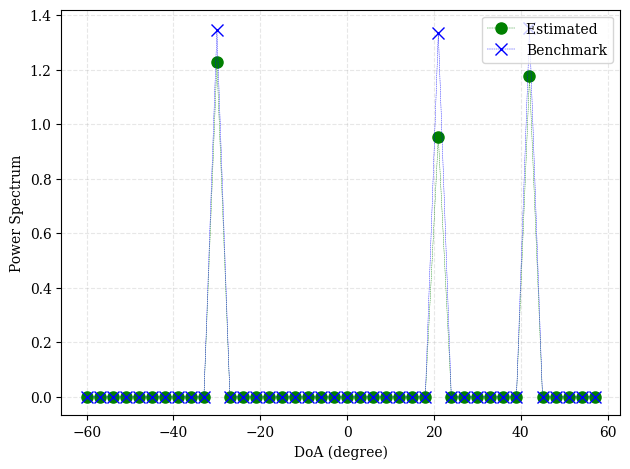

In [68]:
print(max_abs_weight)
plt.rcParams['font.family'] = 'serif'

est=np.squeeze(nu_estimated_np[0])
print(est.shape)
best_resp=keep_largest_elements(est, params.sparsity)


# LISTA
plt.plot(params.grid*(180/np.pi),best_resp,'go--',label='Estimated ',markersize=8,linewidth=0.3)



plt.plot(params.grid*(180/np.pi),nu_original_np[0],'bx--',label='Benchmark',markersize=8,linewidth=0.3)
plt.legend(loc='upper right')

plt.xlabel('DoA (degree)')
plt.ylabel('Power Spectrum')
plt.grid(alpha=0.3,linestyle='--')
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Images/Fig9_DoA_estimation.eps", format="eps", bbox_inches="tight", transparent=True)

plt.show()